# Installations

In [1]:
! pip install deep-sort-realtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.8 MB/s eta 0:00:00


# Imports

In [2]:
import requests
import cv2
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import datetime
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
from PIL import ImageDraw
import numpy as np


In [3]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

# Full Video Player Detector

In [10]:
def player_detections(frame):
  image = Image.fromarray(frame)

  text_labels = ["tennis player"]
  inputs = processor(
    images=image.convert("RGB"), text=text_labels, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = model(**inputs)

  results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
  )

  result = results[0]
  preds = []
  for box, score, labels in zip(result["boxes"], result["scores"], result["labels"]):
    if labels in text_labels:
      box = [int(x) for x in box.tolist()]
      preds.append([[box[0], box[1], box[2]-box[0], box[3]-box[1]], score.item(), 1])

  return preds


In [5]:
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||| ---> frames
#  |  |||||||    ||||||||| | ||||||| |||||||||||||| ||||||   ---> frames with detections (player)
#    2         4                                             ---> consecutive misses

In [11]:
video_path = "/content/video_tennis.mp4"
output_video_path = "output_video_player_track_2.mp4"

video_cap = cv2.VideoCapture(video_path)

tracker = DeepSort(max_age=100) # max number of consecutive misses to allow

frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))
frame_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Number of frames: {frame_count}")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


Number of frames: 226


In [12]:
tracking = []

while video_cap.isOpened():
    start = datetime.datetime.now()
    ret, frame = video_cap.read()
    if not ret: break

    player_bbox = player_detections (frame)
    tracks = tracker.update_tracks (player_bbox, frame=frame)

    # used to determine which players moved the most during the match
    # this enables the removal of the persons who are not movig very much (line judge, etc)
    frame_tracking = []

    if len(player_bbox) > 0:

      for track in tracks:
        if not track.is_confirmed():
          continue

        track_id = track.track_id
        ltrb = track.to_ltrb() # left top right bottom

        xmin, ymin, xmax, ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
        frame_tracking.append([xmin, ymin, track_id])

        cv2.rectangle (frame, (xmin, ymin), (xmax, ymax), (10, 255, 0), 2)
        cv2.putText (frame, "player_" + str(track_id), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

      writer.write(frame)
      end = datetime.datetime.now()
      print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} miliseconds")

    tracking.append(frame_tracking)

video_cap.release()
writer.release()
cv2.destroyAllWindows()


/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


Time to process 1 frame: 3517 miliseconds
Time to process 1 frame: 652 miliseconds
Time to process 1 frame: 601 miliseconds
Time to process 1 frame: 602 miliseconds
Time to process 1 frame: 623 miliseconds
Time to process 1 frame: 657 miliseconds
Time to process 1 frame: 663 miliseconds
Time to process 1 frame: 742 miliseconds
Time to process 1 frame: 670 miliseconds
Time to process 1 frame: 640 miliseconds
Time to process 1 frame: 2952 miliseconds
Time to process 1 frame: 706 miliseconds
Time to process 1 frame: 640 miliseconds
Time to process 1 frame: 637 miliseconds
Time to process 1 frame: 634 miliseconds
Time to process 1 frame: 642 miliseconds
Time to process 1 frame: 3122 miliseconds
Time to process 1 frame: 782 miliseconds
Time to process 1 frame: 722 miliseconds
Time to process 1 frame: 654 miliseconds
Time to process 1 frame: 650 miliseconds
Time to process 1 frame: 644 miliseconds
Time to process 1 frame: 641 miliseconds
Time to process 1 frame: 638 miliseconds
Time to proce

In [13]:
tracking

[[],
 [],
 [[796, 619, '1'], [1637, 401, '2'], [1118, 122, '3']],
 [[797, 618, '1'], [1637, 400, '2'], [1118, 122, '3']],
 [[798, 617, '1'], [1637, 400, '2'], [1118, 122, '3']],
 [[800, 617, '1'], [1637, 400, '2'], [1118, 122, '3']],
 [[802, 618, '1'], [1637, 400, '2'], [1118, 122, '3']],
 [[804, 619, '1'], [1636, 400, '2'], [1118, 122, '3']],
 [[805, 620, '1'], [1636, 400, '2'], [1118, 123, '3']],
 [[806, 620, '1'], [1636, 399, '2'], [1118, 124, '3']],
 [[805, 620, '1'], [1637, 399, '2'], [1118, 125, '3']],
 [[803, 611, '1'], [1637, 399, '2'], [1118, 125, '3']],
 [[797, 614, '1'], [1637, 399, '2'], [1117, 124, '3']],
 [[793, 619, '1'], [1638, 399, '2'], [1117, 122, '3']],
 [[793, 631, '1'], [1638, 399, '2'], [1116, 118, '3']],
 [[794, 632, '1'], [1638, 399, '2'], [1115, 116, '3']],
 [[800, 627, '1'], [1638, 399, '2'], [1115, 115, '3']],
 [[799, 581, '1'], [1638, 399, '2'], [1114, 114, '3']],
 [[798, 538, '1'], [1638, 399, '2'], [1114, 113, '3']],
 [[807, 561, '1'], [1638, 399, '2'], [

# Filter out the non-player detections

In [14]:
def euclid_dist(p1, p2):
  # return np.sqrt ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
  return np.linalg.norm (p1 - p2)


In [15]:
# Calculate the distance that each player has moved
player_ids = []
player_pos = {}
player_dist = {}

for frame in tracking:
  for player in frame:
    player_id = int(player[2])
    if player_id not in player_ids:
      player_pos[player_id] = np.array([player[0], player[1]])
      player_dist[player_id] = 0
      player_ids.append(player_id)
    else:
      player_dist[player_id] = euclid_dist (player_pos[player_id], np.array([player[0], player[1]])) + player_dist[player_id]
      player_pos[player_id] = np.array ([player[0], player[1]])

print(player_dist)


{1: np.float64(1780.1708375592334), 2: np.float64(39.82842712474619), 3: np.float64(1570.2686614790784), 10: np.float64(11.0), 14: np.float64(3.0)}


In [16]:
# [[[803, 619, '1'], [1636, 400, '2'], [1117, 122, '3']],  {1: pos11, 2: pos21, 3: pos31}  {1: 0,                      2: 0,                      3: 0                      }
#  [[803, 619, '1'], [1636, 400, '2'], [1117, 122, '3']],  {1: pos12, 2: pos22, 3: pos32}  {1: dist(pos12,pos11),      2: dist(pos22,pos21),      3: dist(pos32,pos31)      }
#  [[804, 620, '1'], [1636, 400, '2'], [1118, 123, '3']],  {1: pos13, 2: pos23, 3: pos33}  {1: dist(pos13,pos12)+prev, 2: dist(pos23,pos22)+prev, 3: dist(pos33,pos32)+prev }
#  [[805, 620, '1'], [1636, 399, '2'], [1118, 124, '3']],  {1: pos14, 2: pos24, 3: pos34}  {1: dist(pos14,pos13)+prev, 2: dist(pos24,pos23)+prev, 3: dist(pos34,pos33)+prev }


In [17]:
# Sort the lpayers by the total distance they have moved
sorted_player_dist = dict(sorted(player_dist.items(), key=lambda item: item[1], reverse=True))
print(sorted_player_dist)


{1: np.float64(1780.1708375592334), 3: np.float64(1570.2686614790784), 2: np.float64(39.82842712474619), 10: np.float64(11.0), 14: np.float64(3.0)}


In [18]:
# Select the two detected players who have moved the most (the real tennis players)
actual_players = [list(sorted_player_dist.items())[0][0],
                  list(sorted_player_dist.items())[1][0]]
print(actual_players)


[1, 3]


In [19]:
tracking_updated = []

for frame in tracking:
  tr = []
  for player in frame:
    if int(player[2]) in actual_players: # player_id
      tr.append(player)
  tracking_updated.append(tr)

print(tracking_updated)


[[], [], [[796, 619, '1'], [1118, 122, '3']], [[797, 618, '1'], [1118, 122, '3']], [[798, 617, '1'], [1118, 122, '3']], [[800, 617, '1'], [1118, 122, '3']], [[802, 618, '1'], [1118, 122, '3']], [[804, 619, '1'], [1118, 122, '3']], [[805, 620, '1'], [1118, 123, '3']], [[806, 620, '1'], [1118, 124, '3']], [[805, 620, '1'], [1118, 125, '3']], [[803, 611, '1'], [1118, 125, '3']], [[797, 614, '1'], [1117, 124, '3']], [[793, 619, '1'], [1117, 122, '3']], [[793, 631, '1'], [1116, 118, '3']], [[794, 632, '1'], [1115, 116, '3']], [[800, 627, '1'], [1115, 115, '3']], [[799, 581, '1'], [1114, 114, '3']], [[798, 538, '1'], [1114, 113, '3']], [[807, 561, '1'], [1113, 115, '3']], [[817, 594, '1'], [1112, 117, '3']], [[822, 609, '1'], [1112, 119, '3']], [[830, 616, '1'], [1111, 121, '3']], [[831, 622, '1'], [1112, 128, '3']], [[825, 626, '1'], [1113, 131, '3']], [[817, 629, '1'], [1113, 133, '3']], [[807, 633, '1'], [1113, 134, '3']], [[805, 640, '1'], [1111, 135, '3']], [[809, 643, '1'], [1097, 135,

In [ ]:
# ! cp -r /content/output_video_player.mp4 /content/drive/MyDrive/
# ! cp -r /content/output_video_player_1.mp4 /content/drive/MyDrive/


In [20]:
video_path = "/content/video_tennis.mp4"
output_video_path = "output_video_player_track_3.mp4"

video_cap = cv2.VideoCapture(video_path)

tracker = DeepSort(max_age=100) # new line for tracking

frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


In [21]:
tracking = []
k = 0

while video_cap.isOpened():
    start = datetime.datetime.now()
    ret, frame = video_cap.read()
    if not ret: break

    if len(tracking_updated[k]) > 0:
      for player in tracking_updated[k]:
        xmin, ymin = player[0], player[1]
        cv2.rectangle (frame, (xmin, ymin), (xmin + 2, ymin + 2), (10, 255, 0), 2)
        cv2.putText (frame, "player_" + player[2], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

      writer.write(frame)
      end = datetime.datetime.now()
      print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} miliseconds")

    k+=1

video_cap.release()
writer.release()
cv2.destroyAllWindows()


Time to process 1 frame: 39 miliseconds
Time to process 1 frame: 27 miliseconds
Time to process 1 frame: 27 miliseconds
Time to process 1 frame: 29 miliseconds
Time to process 1 frame: 20 miliseconds
Time to process 1 frame: 32 miliseconds
Time to process 1 frame: 29 miliseconds
Time to process 1 frame: 21 miliseconds
Time to process 1 frame: 28 miliseconds
Time to process 1 frame: 45 miliseconds
Time to process 1 frame: 21 miliseconds
Time to process 1 frame: 20 miliseconds
Time to process 1 frame: 22 miliseconds
Time to process 1 frame: 19 miliseconds
Time to process 1 frame: 22 miliseconds
Time to process 1 frame: 23 miliseconds
Time to process 1 frame: 19 miliseconds
Time to process 1 frame: 21 miliseconds
Time to process 1 frame: 18 miliseconds
Time to process 1 frame: 20 miliseconds
Time to process 1 frame: 22 miliseconds
Time to process 1 frame: 17 miliseconds
Time to process 1 frame: 18 miliseconds
Time to process 1 frame: 43 miliseconds
Time to process 1 frame: 32 miliseconds


In [ ]:
frame_count = 0
tracking = []
while video_cap.isOpened():
    start = datetime.datetime.now()
    ret, frame = video_cap.read()
    if not ret:
      break

    player_bbox = player_detections(frame)
    tracks = tracker.update_tracks(player_bbox, frame=frame)
    time_tracking = []
    if len(player_bbox)>0:

      for track in tracks:
        # if the track is not confirmed, ignore it
        if not track.is_confirmed():
            continue

        # get the track id and the bounding box
        track_id = track.track_id
        ltrb = track.to_ltrb()

        xmin, ymin, xmax, ymax = int(ltrb[0]), int(
            ltrb[1]), int(ltrb[2]), int(ltrb[3])

        time_tracking.append([xmin,ymin,track_id])
        # draw the bounding box and the track id



        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (10,255,0), 2)
        cv2.putText(frame, "player_"+str(track_id), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),2)

      writer.write(frame)
      end = datetime.datetime.now()
      print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} miliseconds")

      frame_count +=1
      if frame_count >5000000:
        break
      print(frame_count)


    tracking.append(time_tracking)
video_cap.release()
writer.release()
cv2.destroyAllWindows()

/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


Time to process 1 frame: 463 miliseconds
1
Time to process 1 frame: 406 miliseconds
2
Time to process 1 frame: 401 miliseconds
3
Time to process 1 frame: 431 miliseconds
4
Time to process 1 frame: 405 miliseconds
5
Time to process 1 frame: 413 miliseconds
6
Time to process 1 frame: 402 miliseconds
7
Time to process 1 frame: 406 miliseconds
8
Time to process 1 frame: 409 miliseconds
9
Time to process 1 frame: 401 miliseconds
10
Time to process 1 frame: 402 miliseconds
11
Time to process 1 frame: 412 miliseconds
12
Time to process 1 frame: 405 miliseconds
13
Time to process 1 frame: 404 miliseconds
14
Time to process 1 frame: 402 miliseconds
15
Time to process 1 frame: 403 miliseconds
16
Time to process 1 frame: 408 miliseconds
17
Time to process 1 frame: 409 miliseconds
18
Time to process 1 frame: 399 miliseconds
19
Time to process 1 frame: 404 miliseconds
20
Time to process 1 frame: 408 miliseconds
21
Time to process 1 frame: 415 miliseconds
22
Time to process 1 frame: 401 miliseconds


In [ ]:

model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

In [ ]:
image_url = "test_image.png"
#image = Image.open(requests.get(image_url, stream=True).raw)
image = Image.open(image_url)

# Check for cats and remote controls
text_labels = [["tennis player", "a tennis ball"]]

In [ ]:
inputs = processor(images=image.convert("RGB"), text=text_labels, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    #box_threshold=0.4,
    text_threshold=0.2,
    target_sizes=[image.size[::-1]]
)

In [ ]:
filtered_bbox = []
result = results[0]
for box, score, labels in zip(result["boxes"], result["scores"], result["labels"]):
    if labels == "tennis player" or labels=="a tennis ball":
      box = [round(x, 2) for x in box.tolist()]
      filtered_bbox.append(box)
      print(f"Detected {labels} with confidence {round(score.item(), 3)} at location {box}")

Detected tennis player with confidence 0.728 at location [987.99, 442.83, 1076.34, 586.16]
Detected a tennis ball with confidence 0.332 at location [1297.35, 110.43, 1330.5, 144.87]
Detected a tennis ball with confidence 0.315 at location [797.53, 330.77, 809.6, 343.04]
Detected tennis player with confidence 0.287 at location [961.79, 166.16, 1023.7, 245.81]
Detected a tennis ball with confidence 0.276 at location [793.95, 327.21, 813.43, 346.64]


/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


Image saved as output.png


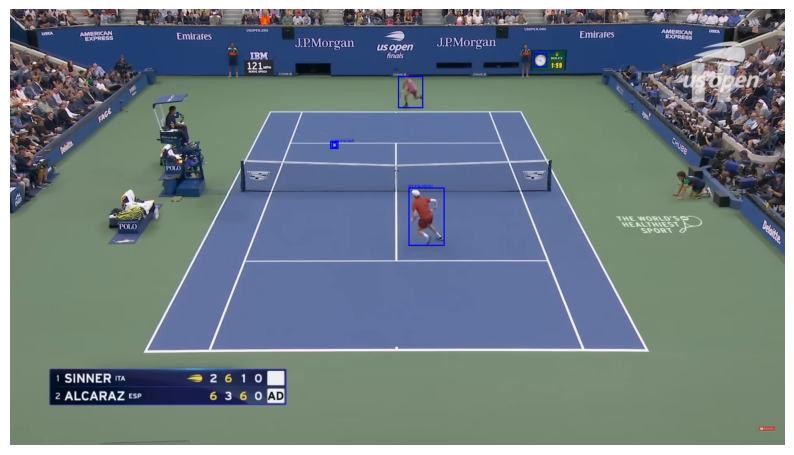

In [ ]:

# Create a drawing object on a copy of the image to avoid modifying the original loaded image
draw_image = image.copy()
draw = ImageDraw.Draw(draw_image)

# Define a color for the bounding boxes
box_color = (0, 0, 255)  # OpenCV uses BGR format (Blue, Green, Red)

# Draw each filtered bounding box
result = results[0]
for box, label in zip(result["boxes"], result["text_labels"]):
    # Convert PIL box coordinates to integers for OpenCV
    box = [int(x) for x in box.tolist()]
    # Draw the bounding box using OpenCV
    draw.rectangle(box, outline=box_color, width=3)
    # Add label text
    draw.text((box[0], box[1] - 10), label, fill=box_color)


# Convert the PIL image to a NumPy array (OpenCV format)
opencv_image = cv2.cvtColor(np.array(draw_image), cv2.COLOR_RGB2BGR)

# Save the image with bounding boxes
output_filename = "output.png"
cv2.imwrite(output_filename, opencv_image)

print(f"Image saved as {output_filename}")

# Display the image with bounding boxes (optional, can remove if only saving is needed)
plt.figure(figsize=(10, 10))
plt.imshow(draw_image)
plt.axis('off') # Hide the axes
plt.show()

# Full Video Player Detector

In [ ]:
model_dino_id = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(model_dino_id)
device = "cuda"
model_dino = AutoModelForZeroShotObjectDetection.from_pretrained(model_dino_id).to(device)

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

In [ ]:
def player_detections(frame):
  image = Image.fromarray(frame)

  text_labels = ["tennis player"]
  inputs = processor(images=image, text=text_labels, return_tensors="pt").to(device)

  with torch.no_grad():
      outputs = model_dino(**inputs)

  preds = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
  )


  results = []
  pred = preds[0]

  for box, score, labels in zip(pred["boxes"], pred["scores"], pred["labels"]):

    if labels in text_labels:
      box = [round(x, 2) for x in box.tolist()]
      print(box)

      results.append([[box[0],box[1],box[2], box[3]], score.item(), 1])

  return results

In [ ]:
video_path = "/content/video_tennis.mp4"
output_video_path = "output_video_player.mp4"

video_cap = cv2.VideoCapture(video_path)

frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

In [ ]:
frame_count = 0
while video_cap.isOpened():
    start = datetime.datetime.now()
    ret, frame = video_cap.read()
    if not ret:
      break

    player_bbox = player_detections(frame)

    if len(player_bbox)>0:
      for p in player_bbox:
        xmin_ball = int(p[0][0])
        ymin_ball = int(p[0][1])
        xmax_ball = int(p[0][2])
        ymax_ball = int(p[0][3])

        cv2.rectangle(frame, (xmin_ball, ymin_ball), (xmax_ball, ymax_ball), (10,255,0), 2)
        cv2.putText(frame, "player", (xmin_ball, ymin_ball-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (225,255,220),2)

    writer.write(frame)
    end = datetime.datetime.now()
    print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} miliseconds")
    frame_count+=1
    if frame_count>100:
      break

video_cap.release()
writer.release()
cv2.destroyAllWindows()

[798.97, 624.63, 899.53, 873.46]
[1637.88, 401.23, 1735.56, 472.69]
[1119.65, 124.3, 1184.82, 210.48]
Time to process 1 frame: 435 miliseconds
[799.06, 620.21, 902.89, 872.69]
[1638.17, 401.2, 1735.53, 472.6]
[1119.63, 123.96, 1184.88, 210.42]
Time to process 1 frame: 383 miliseconds
[799.94, 620.73, 893.2, 871.13]
[1638.48, 401.03, 1735.44, 472.56]
[1119.66, 123.54, 1184.98, 210.13]
Time to process 1 frame: 381 miliseconds
[800.39, 618.6, 898.43, 871.76]
[1638.6, 400.94, 1735.41, 472.6]
[1119.6, 123.42, 1185.03, 210.0]
Time to process 1 frame: 384 miliseconds
[801.57, 618.91, 900.16, 872.02]
[1638.58, 401.04, 1735.62, 472.8]
[1119.63, 123.06, 1184.86, 210.23]
Time to process 1 frame: 382 miliseconds
[803.18, 618.78, 902.57, 872.26]
[1638.51, 401.06, 1735.5, 472.95]
[1119.67, 122.81, 1184.62, 210.25]
Time to process 1 frame: 385 miliseconds
[806.06, 619.27, 903.45, 872.16]
[1638.55, 401.07, 1735.65, 473.0]
[1119.74, 123.07, 1183.21, 209.81]
Time to process 1 frame: 380 miliseconds
[808